# Convolutional AutoEncoder for Cifar dataset

## Backend and Import

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
import keras
from keras import backend as K
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

c:\users\user\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Cifar10 dataset

In [3]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "./models/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]

In [8]:
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


## Convolutional AutoEncoder

In [9]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [10]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
__________

## Train AutoEncoder

In [11]:
# # load pretrained weights
# model.load_weights(saveDir + "AutoEncoder_Cifar10_Deep_weights.05-0.56-0.56.hdf5")

In [12]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'Cifar_Conv_AutoEncoder.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [13]:
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 50000 samples, validate on 7000 samples
Epoch 1/100
49984/50000 [============================>.] - ETA: 0s - loss: 0.5827
Epoch 00001: val_loss improved from inf to 0.57381, saving model to ./models/Cifar_Conv_AutoEncoder.01-0.58-0.57.hdf5
50000/50000 [==============================] - 34s 682us/step - loss: 0.5827 - val_loss: 0.5738
Epoch 2/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.5723
Epoch 00002: val_loss improved from 0.57381 to 0.57206, saving model to ./models/Cifar_Conv_AutoEncoder.02-0.57-0.57.hdf5
50000/50000 [==============================] - 32s 630us/step - loss: 0.5723 - val_loss: 0.5721
Epoch 3/100
49984/50000 [============================>.] - ETA: 0s - loss: 0.5696
Epoch 00003: val_loss improved from 0.57206 to 0.56794, saving model to ./models/Cifar_Conv_AutoEncoder.03-0.57-0.57.hdf5
50000/50000 [==============================] - 31s 626us/step - loss: 0.5696 - val_loss: 0.5679
Epoch 4/100
49920/50000 [============================>.

## Evaluate with test dataset

In [14]:
score = model.evaluate(x_test, x_test, verbose=1)
print(score)

3000/3000 [==============================] - 1s 203us/step
0.563484738667806


## Visualize original image and reconstructed image

In [ ]:
c10test = model.predict(x_test)
c10val = model.predict(x_val)

In [ ]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

In [ ]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
showOrigDec(x_test, c10test)

In [ ]:
showOrigDec(x_test[100:], c10test[100:])

In [ ]:
showOrigDec(x_test[200:], c10test[200:])

In [ ]:
showOrigDec(x_val, c10val)

In [ ]:
showOrigDec(x_val[100:], c10val[100:])

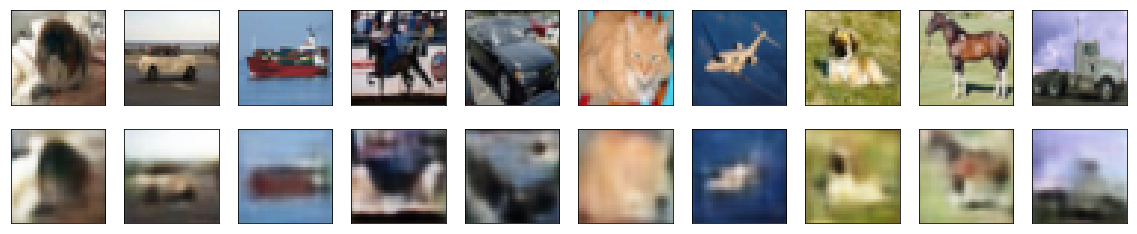

In [23]:
showOrigDec(x_val[200:], c10val[200:])

## Try the Convolutional AutoEncoder on Cifar100

## Load cifar100 dataset

In [24]:
from keras.datasets import cifar100

(x_train100, y_train100), (x_test100, y_test100) = cifar100.load_data()

In [25]:
# normalize data
x_train100 = x_train100.astype('float32')
x_test100 = x_test100.astype('float32')
x_train100 /= 255
x_test100 /= 255

MemoryError: 

In [ ]:
print('x_train100 shape:', x_train100.shape)
print(x_train100.shape[0], 'train samples')
print(x_test100.shape[0], 'test samples')

In [ ]:
score = model.evaluate(x_train100, x_train100, verbose=1)
print(score)

In [ ]:
score = model.evaluate(x_test100, x_test100, verbose=1)
print(score)

## Autoencoder on Cifar100 dateset

In [ ]:
c100train = model.predict(x_train100)
c100test = model.predict(x_test100)

In [ ]:
print("Cifar100 train: {0} \nCifar100 test: {1}"
      .format(np.average(c100train), np.average(c100test)))

In [ ]:
showOrigDec(x_train100, c100train)

In [ ]:
showOrigDec(x_train100[100:], c100train[100:])

In [ ]:
showOrigDec(x_train100[200:], c100train[200:])

In [ ]:
showOrigDec(x_test100, c100test)

In [ ]:
showOrigDec(x_test100[100:], c100test[100:])

In [ ]:
showOrigDec(x_test100[200:], c100test[200:])

In [14]:
import sys
import time
import os
pathWork = os.path.dirname(os.path.realpath("__file__")) + "/../illustration/"
sys.path.append(pathWork)
from sklearn.metrics import silhouette_score
from util import plotScatterDecode, plotProgress, plotCompDecode, plotScatterEncode, addNoise

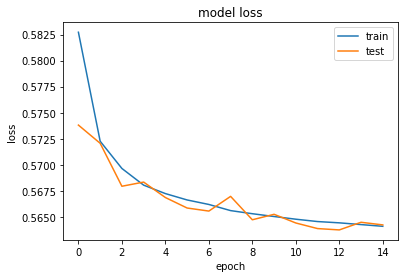

In [15]:
# print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

In [16]:
# encode and decode some digits
# note that we take them from the *test* set
xTest = x_test
yTest = y_test[7000:]
yTest = np.squeeze(yTest, axis=1)
# encodeTest = encoder.predict(xTest)
decodeTest = model.predict(xTest)
# meanEncTest = np.mean(encodeTest, axis=0)
# stdEncTest = np.std(encodeTest, axis=0)

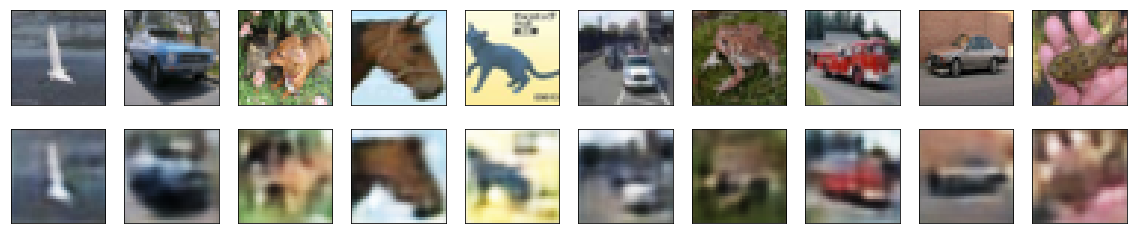

In [17]:
plotCompDecode(xTest, decodeTest, sizeDigit = (32, 32, 3))